# Hoja de trabajo 06
#### Jose Daniel Gomez Cabrera 21429

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sb
from sklearn.compose import make_column_selector as selector
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

In [40]:
houses = pd.read_csv('train.csv')
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1. Cree una variable <strong>dicotómica</strong> por cada una de las categorías de la variable respuesta categórica que creó en hojas anteriores. Debería tener 3 variables dicotómicas (valores 0 y 1) una que diga si la vivienda es cara o no, media o no, económica o no.

In [43]:
houses = pd.read_csv('train.csv')

# Define categories
categories = ['Economic', 'Intermediate', 'Expensive']

# Create a new column with the categories
houses['PriceCategory'] = pd.qcut(houses['SalePrice'], q=len(categories), labels=categories)
houses['PriceCategory'] = houses['PriceCategory'].astype('category')

# Create dummy variables
dummies = pd.get_dummies(houses['PriceCategory'])

# Join the dummy variables to the main dataframe
houses = pd.concat([houses, dummies], axis=1)

# Now you have three dichotomous variables: 'Economic', 'Intermediate', and 'Expensive'
print(houses[['Economic', 'Intermediate', 'Expensive']])

      Economic  Intermediate  Expensive
0            0             0          1
1            0             1          0
2            0             0          1
3            0             1          0
4            0             0          1
...        ...           ...        ...
1455         0             1          0
1456         0             0          1
1457         0             0          1
1458         0             1          0
1459         0             1          0

[1460 rows x 3 columns]


2. Use los mismos conjuntos de entrenamiento y prueba que utilizó en las hojas anteriores.

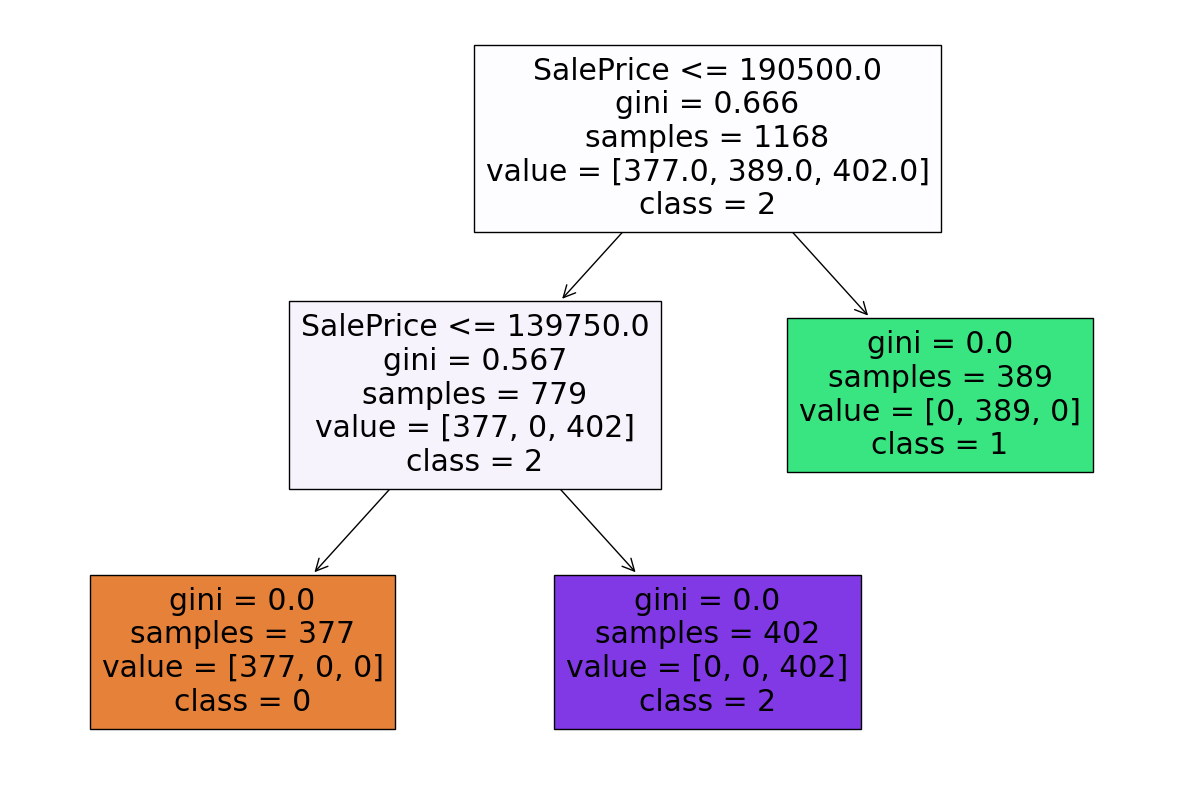

In [35]:
y = houses.copy().pop('PriceCategory')
X = houses

# Convertir las variables categóricas a forma numerica
X_dummy = pd.get_dummies(X)

# Dividir tus datos y entrenar modelo
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2,  random_state=42)

# Instanciar el arbol y su profundidad
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
# Entrenar arbol de acuerdo a los datos de entrenamiento
clf.fit(X_train, y_train)

# Graficar arbol de clasificacion
plt.figure(figsize=(15, 10))
tree.plot_tree(clf, feature_names=X_dummy.columns, class_names=['0','1','2'], filled=True)
plt.show()

Confussion matrix: 
[[110   0   0]
 [  0  94   0]
 [  0   0  88]]

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1 score: [1. 1. 1.]


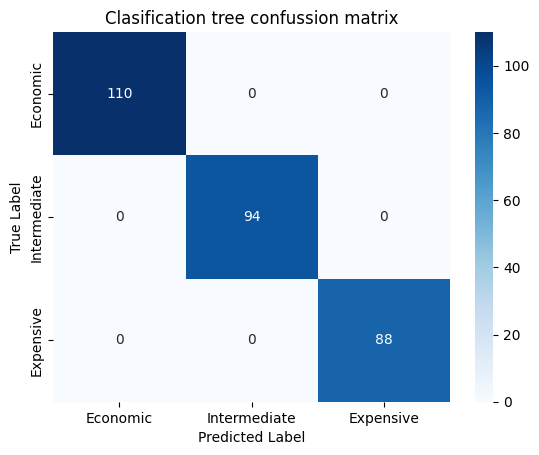

In [36]:
# Predecir etiquetas para los datos de prueba
y_pred = clf.predict(X_test)

# Instanciar matriz de confusión
confussionMatrix = confusion_matrix(y_test, y_pred)

# Calcular metricas de evaluacion de la matriz de confusion
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Mostrar resultados
print(f"Confussion matrix: \n{confussionMatrix}\n")
print(f"Accuracy: {format(accuracy)}")
print(f"Precision: {format(precision)}")
print(f"Recall: {format(recall)}")
print(f"F1 score: {format(f1)}")

# Visualizar la matriz de confusión
sb.heatmap(
  confussionMatrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Economic', 'Intermediate', 'Expensive'],
  yticklabels=['Economic', 'Intermediate', 'Expensive']
)
plt.title('Clasification tree confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### Validación cruzada

In [37]:
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(houses)
categorical_columns = categorical_columns_selector(houses)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns)])

param_grid = {"max_depth": np.arange(2, 10, 1)}
pipeline = Pipeline(
    [('preprocessor',preprocessor),
    ('regressor',DecisionTreeClassifier())])
params = [{
    "regressor__max_depth": np.arange(2, 10, 1)
}]
crossoverModel = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")
crossoverModel.fit(X_train,y_train)
crossoverModel.best_params_

crossoverModel_pred = crossoverModel.predict(X_test)
print("Crossover model")

# crossoverModel_pred
for i in range(0, len(crossoverModel_pred)):
    print(f"Predicted: {crossoverModel_pred[i]}, Real: {y_test.iloc[i]}")

Crossover model
Predicted: Economic, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Economic
Predicted: Intermediate, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Economic, Real: Economic
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Intermediate, Real: Economic
Predicted: Expensive, Real: Expensive
Predicted: Intermediate, Real: Intermediate
Predicted: Expensive, Real: Expensive
Predicted: Expensive, Real: Intermediate
Predicted: Economic, Real: Economic
Predicted: Expensive, Real: Expensive
Predict

C:\Users\dellg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Confussion matrix: 
[[84  5 21]
 [ 2 82 10]
 [25 26 37]]

Accuracy: 0.6952054794520548
Precision: [0.75675676 0.72566372 0.54411765]
Recall: [0.76363636 0.87234043 0.42045455]
F1 score: [0.760181   0.79227053 0.47435897]


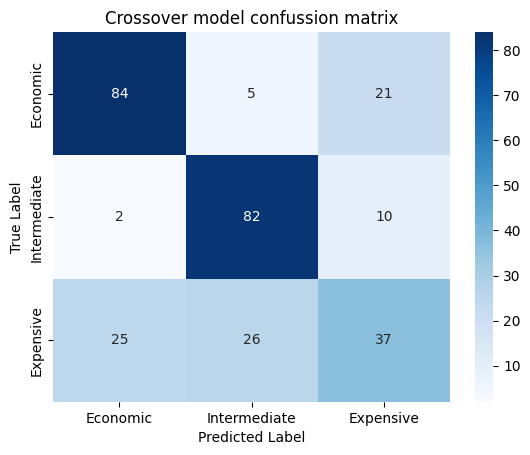

In [38]:
# Predecir etiquetas para los datos de prueba
crossoverModel_pred = crossoverModel.predict(X_test)

# Instanciar matriz de confusión
confussionMatrix = confusion_matrix(y_test, crossoverModel_pred)

# Calcular metricas de evaluacion de la matriz de confusion
accuracy = accuracy_score(y_test, crossoverModel_pred)
precision = precision_score(y_test, crossoverModel_pred, average=None)
recall = recall_score(y_test, crossoverModel_pred, average=None)
f1 = f1_score(y_test, crossoverModel_pred, average=None)

# Mostrar resultados
print(f"Confussion matrix: \n{confussionMatrix}\n")
print(f"Accuracy: {format(accuracy)}")
print(f"Precision: {format(precision)}")
print(f"Recall: {format(recall)}")
print(f"F1 score: {format(f1)}")

# Visualizar la matriz de confusión
sb.heatmap(
  confussionMatrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Economic', 'Intermediate', 'Expensive'],
  yticklabels=['Economic', 'Intermediate', 'Expensive']
)
plt.title('Crossover model confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

3. Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código. Use validación cruzada.

Quitar del conjunto de datos aquellas variables que no se aportan información relevante para la elaboración de modelos como el id, nombre, etc.

In [53]:
houses = pd.read_csv('train.csv')

# Define categories
categories = ['Economic', 'Intermediate', 'Expensive']

# Create a new column with the categories
houses['PriceCategory'] = pd.qcut(houses['SalePrice'], q=len(categories), labels=categories)
houses['PriceCategory'] = houses['PriceCategory'].astype('category')

# Create dummy variables
dummies = pd.get_dummies(houses['PriceCategory'])

# Join the dummy variables to the main dataframe
houses = pd.concat([houses, dummies], axis=1)

# Now you have three dichotomous variables: 'Economic', 'Intermediate', and 'Expensive'
print(houses[['Economic', 'Intermediate', 'Expensive']])

      Economic  Intermediate  Expensive
0            0             0          1
1            0             1          0
2            0             0          1
3            0             1          0
4            0             0          1
...        ...           ...        ...
1455         0             1          0
1456         0             0          1
1457         0             0          1
1458         0             1          0
1459         0             1          0

[1460 rows x 3 columns]


In [54]:
houses.drop(columns=["Id"],axis=1, inplace=True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   int64   
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   Alley          91 non-null     object  
 6   LotShape       1460 non-null   object  
 7   LandContour    1460 non-null   object  
 8   Utilities      1460 non-null   object  
 9   LotConfig      1460 non-null   object  
 10  LandSlope      1460 non-null   object  
 11  Neighborhood   1460 non-null   object  
 12  Condition1     1460 non-null   object  
 13  Condition2     1460 non-null   object  
 14  BldgType       1460 non-null   object  
 15  HouseStyle     1460 non-null   object  
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   in

- Alley no posee 94.8 % de sus datos, entonces la vamos a eliminar
- Pero LotFrontage solo le falta el 17.7% entonces la llenaremos con la media

In [55]:
houses.drop(columns=["Alley"],axis=1, inplace=True)
houses["LotFrontage"].fillna(np.nanmedian(houses["LotFrontage"],), inplace=True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   int64   
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   LotShape       1460 non-null   object  
 6   LandContour    1460 non-null   object  
 7   Utilities      1460 non-null   object  
 8   LotConfig      1460 non-null   object  
 9   LandSlope      1460 non-null   object  
 10  Neighborhood   1460 non-null   object  
 11  Condition1     1460 non-null   object  
 12  Condition2     1460 non-null   object  
 13  BldgType       1460 non-null   object  
 14  HouseStyle     1460 non-null   object  
 15  OverallQual    1460 non-null   int64   
 16  OverallCond    1460 non-null   int64   
 17  YearBuilt      1460 non-null   in